# Wstęp
W drugiej części projektu przeprowadzamy Eksploracyjną Analizę Danych (EDA) na zbiorze danych przepisów kulinarnych, które zostały wcześniej pobrane. Celem tej analizy jest lepsze zrozumienie struktury danych, identyfikacja brakujących wartości, analiza rozkładu poszczególnych zmiennych oraz przetworzenie i wizualizacja danych w celu uzyskania wartościowych wniosków.

## Import bibliotek

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pobieranie danych z Google drive aby mieć dostęp do danych przechowywanych na dysku
!cp '/content/drive/My Drive/PK-DS-JZTW-dane/'* /content

## Ekspoloracja i czyszczenie danych

In [ ]:
# Wczytuje dane
df_recipes = pd.read_csv('df_recipes.csv')

In [ ]:
# Konwersja kolumny 'vegetarian' na nowy typ boolean, który obsługuje wartości NaN
df_recipes['vegetarian'] = df_recipes['vegetarian'].astype('boolean')

# Przygotowanie danych (konwersja typów i obsługa NaN), co pozwala na dalsza analizę
df_recipes['rating'] = pd.to_numeric(df_recipes['rating'], errors='coerce')
df_recipes['opinions_count'] = pd.to_numeric(df_recipes['opinions_count'], errors='coerce')

# Sprawdzenie zmian
print(df_recipes['vegetarian'].dtype)
print(df_recipes['rating'].dtype)
print(df_recipes['opinions_count'].dtype)

boolean
float64
float64


In [ ]:
df_recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category            2557 non-null   object 
 1   recipe_title        2557 non-null   object 
 2   ingredients         2555 non-null   object 
 3   preparation_method  2557 non-null   object 
 4   rating              2266 non-null   float64
 5   opinions_count      757 non-null    float64
 6   preparation_time    1797 non-null   object 
 7   vegetarian          1797 non-null   boolean
dtypes: boolean(1), float64(2), object(5)
memory usage: 145.0+ KB


In [ ]:
# tworze kopie danych
df_recipes = pd.read_parquet('df_recipes.parquet')
df_copy = df_recipes.copy()
df_copy.to_csv('df_copy.csv')
df_copy.to_parquet('df_copy.parquet')

In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category            2557 non-null   object 
 1   recipe_title        2557 non-null   object 
 2   ingredients         2555 non-null   object 
 3   preparation_method  2557 non-null   object 
 4   rating              2266 non-null   float64
 5   opinions_count      757 non-null    float64
 6   preparation_time    1797 non-null   object 
 7   vegetarian          1797 non-null   boolean
dtypes: boolean(1), float64(2), object(5)
memory usage: 145.0+ KB


In [ ]:
df_copy.head(3)

,category,recipe_title,ingredients,preparation_method,rating,opinions_count,preparation_time,vegetarian
0,sniadania,Jajka z rzeżuchą,10 jajek;4 łyżki majonezu;2 łyżeczki musztardy...,Jajka ugotować na twardo (6 minut od zagotowan...,NaN,NaN,None,<NA>
1,sniadania,Pasta z fasoli,1 puszka białej fasolki (400 g);150 g korzenia...,Fasolkę odcedzić na sitku. Selera obrać i pokr...,NaN,NaN,None,<NA>
2,sniadania,Jajka z majonezem truflowym,5 jajek;2 łyżki majonezu;ok. 2 łyżeczek pasty ...,"Jajka ugotować na twardo, obrać ze skorupek, p...",NaN,NaN,None,<NA>


In [ ]:
# Sprawdzam rozkład liczby opinii dla przepisów kulinarnych (22 przepisy mają 11 opinii)
df_copy['opinions_count'].value_counts()

opinions_count
11.0     22
9.0      21
6.0      20
13.0     19
10.0     18
         ..
68.0      1
276.0     1
166.0     1
151.0     1
155.0     1
Name: count, Length: 161, dtype: int64

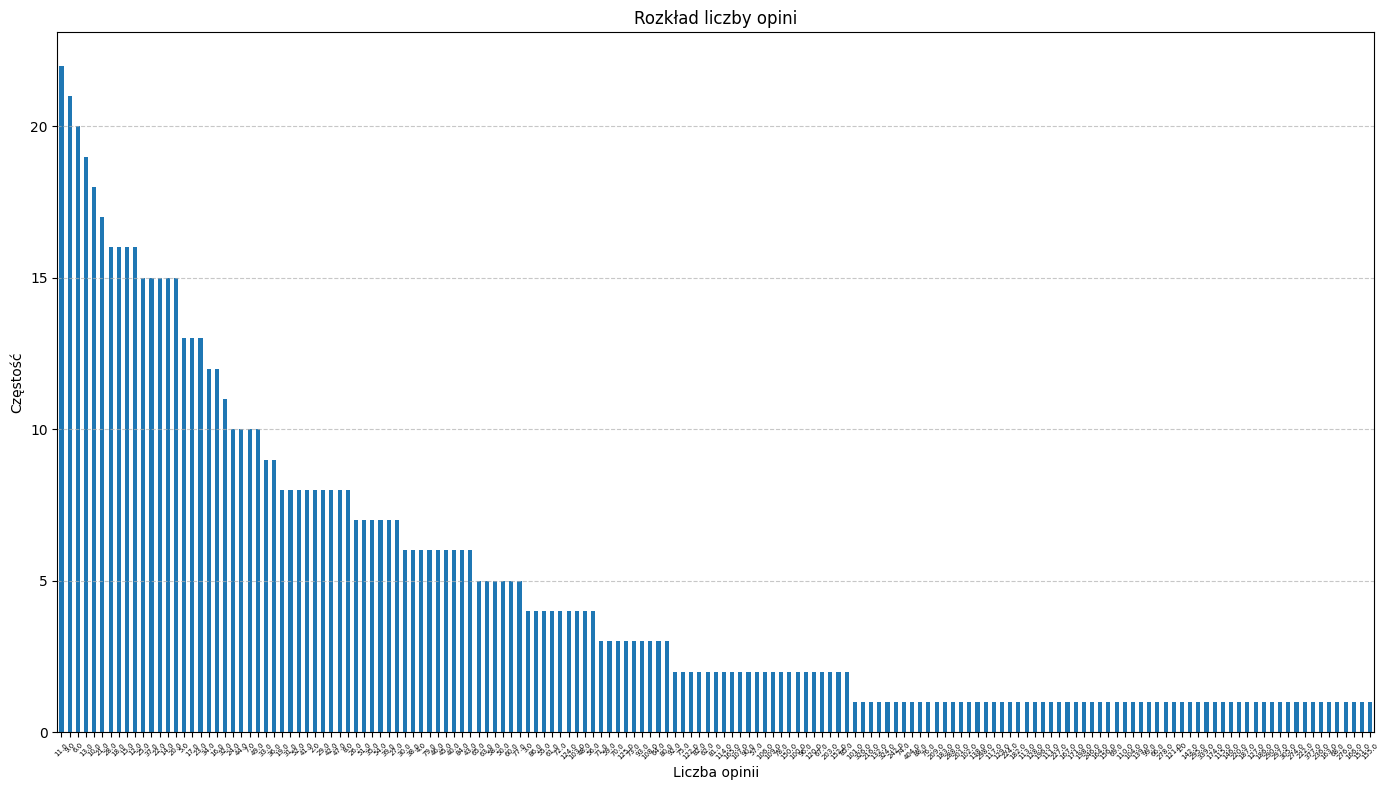

In [ ]:
# Tworzymy do tego wizualizację, możemy przez to zobaczyć jak często przepisy otrzymują określoną liczbę opinii od użytkowników
plt.figure(figsize=(14,8))
df_copy['opinions_count'].value_counts().plot(kind='bar')
plt.title('Rozkład liczby opini')
plt.xlabel('Liczba opinii')
plt.ylabel('Częstość')
plt.xticks(rotation=45, fontsize=5)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Dodajemy siatkę w tle dla osi Y
plt.tight_layout()  # Automatycznie dostosowuje elementy wykresu, aby nie zachodziły na siebie
plt.show()

Wnioski, które możemy tu zobaczyć to dla niskich wartości np. 1-5 opinii, większość przepisów otrzymuje małą liczbę opini, może to oznaczać że użytkownicy często próbują nowe przepisy ale rzadko dzielą sie swoimi opiniami, pojedyńcze słupki dla większych wartości np. 50, 100 opinii wskazuje to na kilka przepisów, które są wyjątkowo popularne i mają dużo recenzji co może oznaczać że przepisy są szczególnie dobre albo są mocno promowane, równomierne rozłożenie opinii mówi nam że możemy mieść zarówno przepisy, które są mało znane, jak i te które są bardzo popularne.

In [ ]:
# Sprawdzam brakujących wartości
print(df_copy.isnull().sum())

category                 0
recipe_title             0
ingredients              2
preparation_method       0
rating                 291
opinions_count        1800
preparation_time       760
vegetarian             760
dtype: int64


In [ ]:
# Sprawdzam unikalne wartości w df_copy['preparation_time']
df_copy['preparation_time'].value_counts()

preparation_time
30 min.            443
60 min.            250
45 min.            248
15 min.            208
90 min.             77
15 min              63
30 min              61
40 min.             59
20 min.             48
25 min.             47
35 min.             28
10 min.             27
60 min              25
20 min              19
50 min.             19
45 min              18
25 min              17
10 min              14
50 min              13
40 min              13
5 min.              12
- min.               9
35 min               7
70 min               6
90 min               5
55 min.              5
80 min               4
5 min                4
80 min.              4
120 min.             4
180 min              3
70 min.              3
120 min              3
75 min.              2
100 min              2
55 min               2
175 min.             2
160 min              2
95 min               2
57 min.              2
Brak informacji      2
150 min.             1
110 min.         

In [ ]:
# Usuwanie min. i min za pomocą regex
df_copy['preparation_time'] = pd.to_numeric(df_copy['preparation_time'].str.replace(' min\.?', '', regex=True), errors='coerce')

In [ ]:
# Sprawdzam ponownie unikalne wartości w df_copy['preparation_time']
df_copy['preparation_time'].value_counts()

preparation_time
30.0     504
60.0     275
15.0     271
45.0     266
90.0      82
40.0      72
20.0      67
25.0      64
10.0      41
35.0      35
50.0      32
5.0       16
70.0       9
80.0       8
120.0      7
55.0       7
95.0       3
180.0      3
75.0       2
175.0      2
160.0      2
110.0      2
100.0      2
57.0       2
85.0       1
73.0       1
48.0       1
135.0      1
65.0       1
140.0      1
210.0      1
105.0      1
240.0      1
34.0       1
130.0      1
150.0      1
Name: count, dtype: int64

In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category            2557 non-null   object 
 1   recipe_title        2557 non-null   object 
 2   ingredients         2555 non-null   object 
 3   preparation_method  2557 non-null   object 
 4   rating              2266 non-null   float64
 5   opinions_count      757 non-null    float64
 6   preparation_time    1786 non-null   float64
 7   vegetarian          1797 non-null   boolean
dtypes: boolean(1), float64(3), object(4)
memory usage: 145.0+ KB


In [ ]:
# Podstawowe statystyki dla kolum numerycznych
print(df_copy[['rating', 'opinions_count', 'preparation_time']].describe().T)

                   count       mean        std  min   25%   50%   75%    max
rating            2266.0   4.532321   0.209980  0.0   4.5   4.5   4.5    5.0
opinions_count     757.0  48.742404  56.226074  1.0  15.0  31.0  57.0  404.0
preparation_time  1786.0  39.338746  23.419641  5.0  25.0  30.0  50.0  240.0


Większość przepisów jest oceniana bardzo wysoko z medianą wynoszącą 4.5 i srędnią ok 4.53, niskie odchylenie standarowe sugeruje, że oceny są dość spójne. średnia liczba opini wynosi ok 49, duże odchylenie standardowe 56.23 i maksymalna liczba opini 404 wskazują na znaczną zmienność w liczbie opinii, niektóre są znacznie popularne niż inne. Średni czas przygotowania wynosi ok 39 minut jednak odchylenie standardowe wynoszące 23.42 sugeruje że niektóre przepisy mogą być znacznie krótsze lub dłuższe. najdłuższy czas przygotowania wynosił 240 minut. Niektóre przepisy mają oceny równe 0 co może wskazywać na brak oceny lub błędne dane.

In [ ]:
# "Statystyki" dla kolumny vegetarian
# Liczę wartości True, False i NaN
vegetarian_nan_count = df_copy['vegetarian'].isnull().sum()
vegetarian_true_count = df_copy['vegetarian'].sum()  # True jest traktowane jako 1
vegetarian_false_count = len(df_copy) - vegetarian_true_count - vegetarian_nan_count  # False jest traktowane jako 0, więc musimy odjąć liczbę NaN

print(f"Vegetarian True: {vegetarian_true_count}")
print(f"Vegetarian False: {vegetarian_false_count}")
print(f"Vegetarian NaN: {vegetarian_nan_count}")

Vegetarian True: 1658
Vegetarian False: 139
Vegetarian NaN: 760


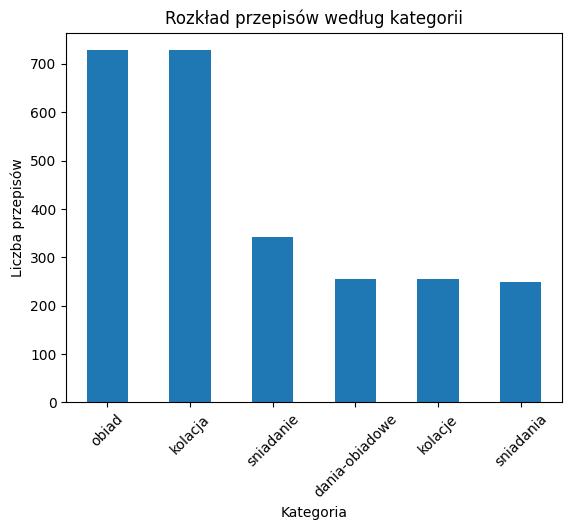

In [ ]:
# Analiza liczności kategorii
df_copy['category'].value_counts().plot(kind='bar')
plt.title('Rozkład przepisów według kategorii')
plt.xlabel('Kategoria')
plt.ylabel('Liczba przepisów')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Podmiana wartości w kolumnie 'category'
df_copy['category'] = df_copy['category'].replace({
    'sniadania': 'sniadanie',
    'dania-obiadowe': 'obiad',
    'kolacje': 'kolacja'
})

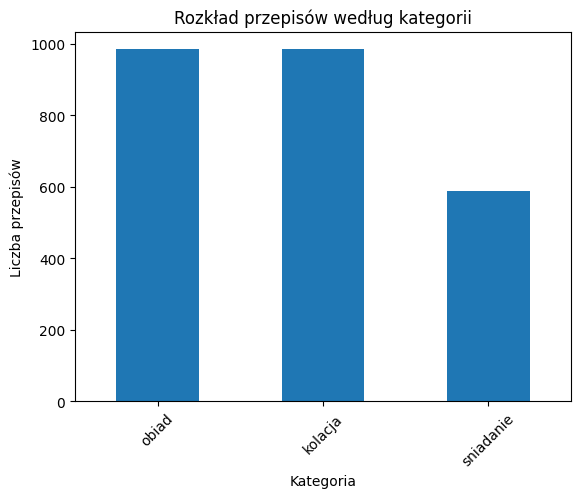

In [ ]:
# Ponowna analiza liczności kategorii
# Rysuję wykres słupkowy
df_copy['category'].value_counts().plot(kind='bar')
plt.title('Rozkład przepisów według kategorii')
plt.xlabel('Kategoria')
plt.ylabel('Liczba przepisów')
plt.xticks(rotation=45)
plt.show()

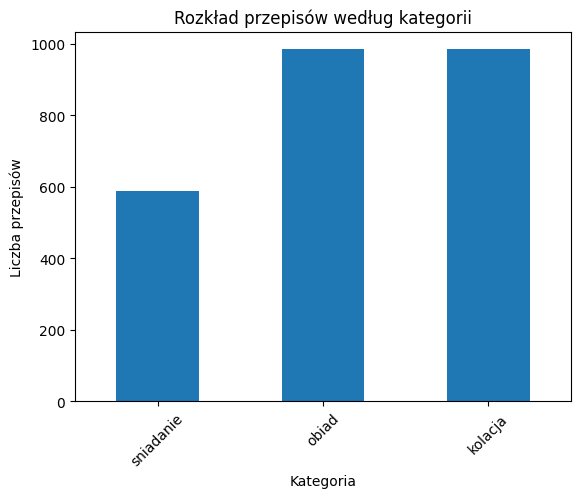

In [ ]:
# Definiuję żądaną kolejność kategorii na rysunku
categories_order = ['sniadanie', 'obiad', 'kolacja']

# Używam funkcji .reindex() do sortowania serii value_counts() zgodnie z zdefiniowaną kolejnością
category_counts_ordered = df_copy['category'].value_counts().reindex(categories_order)

# Rysuję wykres słupkowy z posortowanymi danymi
category_counts_ordered.plot(kind='bar')
plt.title('Rozkład przepisów według kategorii')
plt.xlabel('Kategoria')
plt.ylabel('Liczba przepisów')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Sprawdzamy w ilu kolumnach są NaN
df_copy.isna().any().count()

8

In [ ]:
# Sprawdzamy, które wiersze nie mają podanych składników
df_copy[df_copy['ingredients'].isna()]

,category,recipe_title,ingredients,preparation_method,rating,opinions_count,preparation_time,vegetarian
1842,kolacja,Brak tytułu,None,Brak sposobu przygotowania,0.0,NaN,NaN,False
1854,kolacja,Brak tytułu,None,Brak sposobu przygotowania,0.0,NaN,NaN,False


In [ ]:
# Usuwamy wiersze bez tytułu i sposobu przygotowania (powyższe)
df_copy = df_copy[
    ~((df_copy['recipe_title'] == 'Brak tytułu') |
    (df_copy['preparation_method'] == 'Brak sposobu przygotowania') |
    (df_copy['ingredients'].isna()))
]

In [ ]:
# Sprawdzamy efekt
df_copy[df_copy['ingredients'].isna()]

,category,recipe_title,ingredients,preparation_method,rating,opinions_count,preparation_time,vegetarian


In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2555 entries, 0 to 2556
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category            2555 non-null   object 
 1   recipe_title        2555 non-null   object 
 2   ingredients         2555 non-null   object 
 3   preparation_method  2555 non-null   object 
 4   rating              2264 non-null   float64
 5   opinions_count      757 non-null    float64
 6   preparation_time    1786 non-null   float64
 7   vegetarian          1795 non-null   boolean
dtypes: boolean(1), float64(3), object(4)
memory usage: 164.7+ KB


In [ ]:
# Klonuję z Git'a stopwordsy
!git clone https://github.com/bieli/stopwords

Cloning into 'stopwords'...
remote: Enumerating objects: 22, done.
Receiving objects: 100% (22/22), 7.04 KiB | 7.04 MiB/s, done.
Resolving deltas: 100% (3/3), done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22


In [ ]:
# Dodaję do pliku polish.stopwords.txt dodatkowe słowa
! cp ./stopwords/polish.stopwords.txt .

additional_stopwords_list = ['sztuka', 'g', 'łyżka', 'opakowanie', 'ml',
                             'łyżeczka', 'sztuk', '1', '2', '3','4',
                             'łyżki', 'gramów', 'sztuki', 'mililitrów',
                             'łyżeczki', 'dag', 'null']

# Iteruję po liście słów stopu i dopisuję każde z nich do pliku
for word in additional_stopwords_list:
    # Używam polecenia echo z przekierowaniem >> do dopisania słowa do pliku
    !echo {word} >> polish.stopwords.txt

In [ ]:
# Wczytuję słowa stopu z pliku
with open('polish.stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

# Usuwam pewne znaki ze składników
def remove_some_chars(text):
    # Usuwam wszystkie cyfry (\d+), średniki (;), kropki (.) oraz ukośniki (/) znaki równości oraz min. i min
    return re.sub(r'\d+|;|\.|/|%|=', '', text)

# Usuwam stopwordsy ze składników
def remove_stopwords(text):
    words = text.split()  # Dzielę text na słowa
    filtered_words = [word for word in words if word not in stopwords]  # Usuwam słowa stopu
    return ' '.join(filtered_words)  # Łączę słowa, które pozostały z powrotem w tekst

# Standaryzuję nazwy jednostek, czyli zamieniam słowa w składnikach
# po lewej na słowa po prawej tego słownika
def standardize_units(ingredient):
    units_map = {
            'gram': 'g',
            'gramy': 'g',
            'gów': 'g',
            '(g)': 'g',
            'dekag': 'dag',
            'kilogram': 'kg',
            'kilogramy': 'kg',
            'kg': 'kg',
            'łyżki': 'łyżka',
            'łyżek': 'łyżka',
            'łyżeczki': 'łyżeczka',
            'łyżeczek': 'łyżeczka',
            'szklanki': 'szklanka',
            'szklanek': 'szklanka',
            'sztuki' : 'sztuka',
            'szczypty': 'szczypta',
            'szczypt': 'szczypta',
            'szczyptaa' : 'szczypta',
            'kropli': 'kropla',
            'kropel': 'kropla',
            'mililitr': 'ml',
            'mililitry': 'ml',
            'mlów' : 'ml',
            'masła': 'masło',
            'litry': 'l',
            'litrow': 'l',
            'kostki': 'kostka',
            'kostek': 'kostka',
            'pęczek': 'pęczek',
            'pęczki': 'pęczek',
            'ząbek': 'ząbki',
            'ząbki': 'ząbki',
            'główki': 'główka',
            'główek': 'główka',
            'kawałek': 'kawałki',
            'kawałki': 'kawałki',
            'wody': 'woda',
            # 'Knorr' : 'przyprawa' # to jednak zostawiam, bo może być znaczące
            }
    for long_form, short_form in units_map.items():
        ingredient = ingredient.replace(long_form, short_form)
    return ingredient

# Rozdzielam ilości od składników
def split_quantity_from_ingredient(ingredient):
    match = re.match(r"([\d\s\w\.]+)\s(.+)", ingredient)
    if match:
        quantity = match.group(1)
        ingredient_name = match.group(2)
        return {'quantity': quantity, 'ingredient': ingredient_name}
    else:
        return {'quantity': '', 'ingredient': ingredient}

# Tu wywołuję powyższe funkcje na konkretnej komórce kolumny `ingredients`
def process_ingredients(ingredients_text):
    processed_ingredients = []
    for ingredient in ingredients_text.split(';'):
        ingredient = ingredient.strip()
        ingredient = remove_some_chars(ingredient)
        ingredient = standardize_units(ingredient)
        ingredient = remove_stopwords(ingredient)
        processed = split_quantity_from_ingredient(ingredient)
        processed_ingredients.append(processed)
    return processed_ingredients

# Używam funkcji do przetworzenia kolumny `ingredients` i tworzę nową kolumnę
df_copy['processed_ingredients'] = df_copy['ingredients'].apply(process_ingredients)

# Tworzę listę z kolumny processed_ingredients
processed_ingredients_list = df_copy['processed_ingredients'].tolist()

# Tworzę listę składników, usuwając puste stringi
all_ingredients = []
for ingredient_group in processed_ingredients_list:
  for ingredient_dict in ingredient_group:
    if ingredient_dict['ingredient']:
      all_ingredients.append(ingredient_dict['ingredient'])

# Zliczam częstotliowość wystąpienia składników i drukuję 30 pierwszych
ingredient_counts = Counter(all_ingredients)
print("30 najczęściej występujących składników:")
for ingredient, count in ingredient_counts.most_common(30):
    print(f"{ingredient}: {count}")

30 najczęściej występujących składników:
Knorr: 1321
szczypta: 694
cebula: 693
czosnku: 652
szklanka: 479
woda: 398
jajka: 382
masło: 367
kurczaka: 342
olej: 326
sól: 318
pieprz: 307
pietruszki: 274
oliwek: 273
pęczek: 258
śmietana: 255
jajko: 251
papryka: 229
mielony: 210
mleko: 207
cytryny: 195
czerwona: 194
cukinia: 193
puszki: 188
oliwa: 186
smażenia: 167
mąka: 155
pieczarki: 155
oliwy: 150
vergine: 148


Usunięcie stop word, czyli słów które zazwyczaj nie wnoszą istotnych informacji do analizay tj, sójniki, zaimki, przyimki, pozwala to na oczyszczenie danych tekstowych, dzięki temu możemy skupić się na bardziej istotnych słowach, poprzez usunięcie stop wprd zmiejszamy również rozmiar przetwarzanych danych co może zwiększyć efektywność algorytmów przetwarzania tekstu i obniżyć czas obliczeń jak również poprawić wyniki modeli.

In [ ]:
# Sprawdzamy wynik przetworzenia dla  przykładowego wiersza nr 2540
df_copy['processed_ingredients'][2550]

[{'quantity': 'płatków owsianych płatków jaglanych mleka roślinnego',
  'ingredient': '(np migdałowego) baobabu nasion chia nasion słonecznika orzechów włoskich płatków migdałów malin borówek'}]

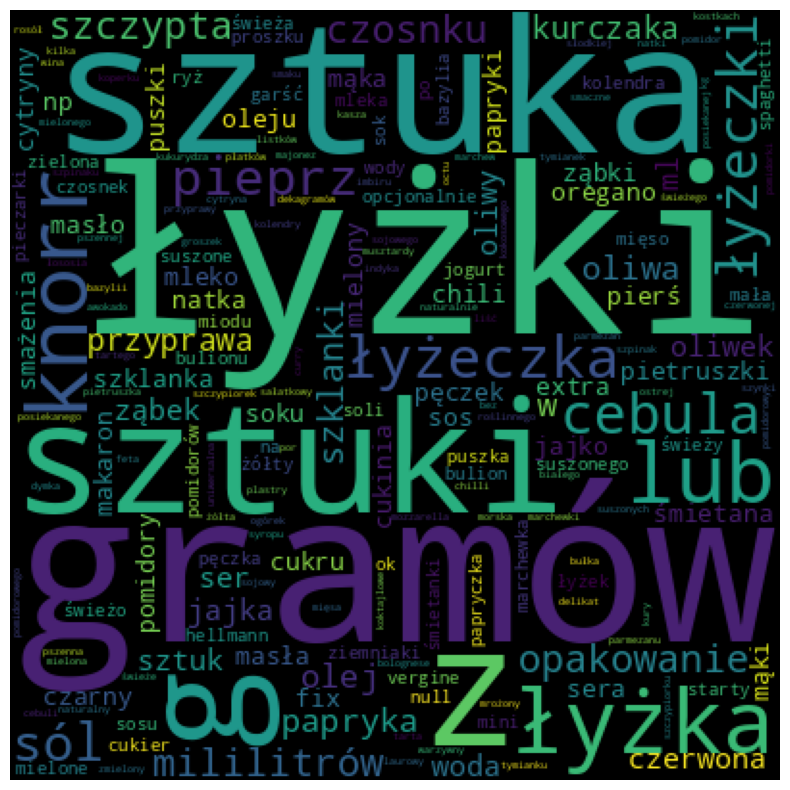

In [ ]:
# Analizuję składniki, najczęściej występujące - chmura słów w kolumnie ingredients
wc = WordCloud(width=400, height=400, collocations=False).generate(' '.join(df_copy['ingredients']).lower())

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

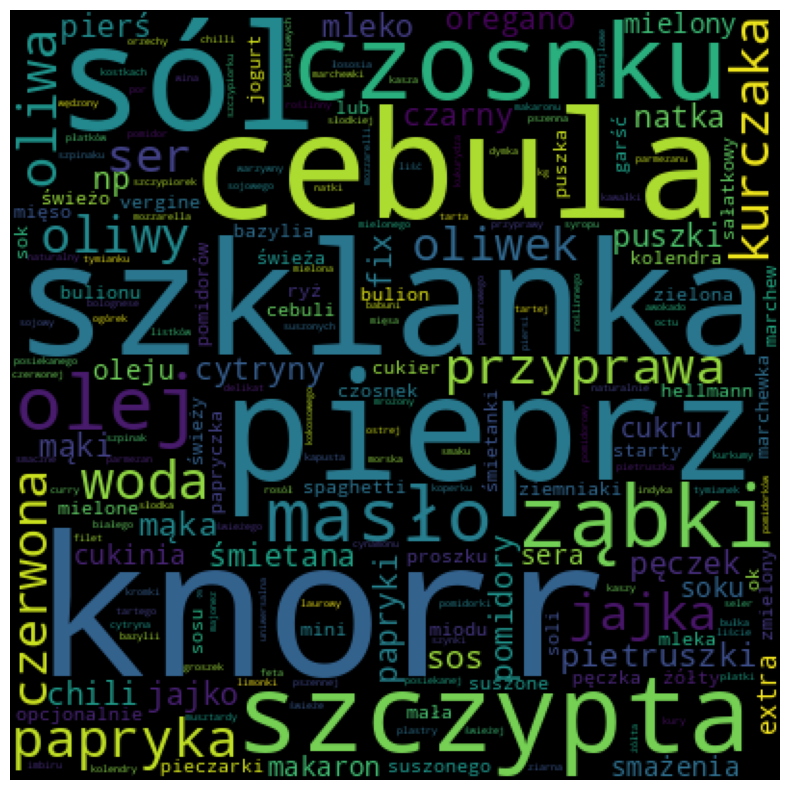

In [ ]:
# # Analizuję składniki, najczęściej występujące - chmura słów w kolumnie processed_ingredients
processed_ingredients_list = df_copy['processed_ingredients'].tolist()

# Sprawdzam typ elementów listy
if isinstance(processed_ingredients_list[0], list):
  # Jeśli to lista, potencjalnie zawierająca słowniki składników
  all_ingredients = []
  for ingredient_group in processed_ingredients_list:
    for ingredient_dict in ingredient_group:
      all_ingredients.extend(ingredient_dict.values())
else:
  # Jeśli to lista słowników, przejdź bezpośrednio do łączenia
  all_ingredients = []
  for ingredient_dict in processed_ingredients_list:
    all_ingredients.extend(ingredient_dict.values())

# Łączę składniki w jeden ciąg tekstowy
all_ingredients_text = ' '.join(all_ingredients).lower()

# Tworzę chmurę słów
wc = WordCloud(width=400, height=400, collocations=False).generate(all_ingredients_text)

# Wyświetlam chmurę słów
plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
# Tworzymy funkcję dict_to_string które przekształca listę słowników w pojedyńczy string, w którym składniki oddzielone są przecinkami
def dict_to_string(list_of_dicts):
    # Zakładamy, że każdy element w 'list_of_dicts' jest słownikiem
    # zawierającym klucze 'quantity' i 'ingredient'
    # Zmodyfikowana funkcja sprawdza, czy otrzymany argument jest rzeczywiście listą słowników
    if isinstance(list_of_dicts, list) and all(isinstance(d, dict) for d in list_of_dicts):
        return ', '.join([f"{d.get('quantity', '')} {d.get('ingredient', '')}".strip() for d in list_of_dicts])
    else:
        # Jeśli nie, zwraca pusty string lub inny domyślny komunikat
        return ''

# Zastosowanie funkcji do kolumny 'processed_ingredients' i nadpisanie tej kolumny
df_copy['processed_ingredients'] = df_copy['processed_ingredients'].apply(dict_to_string)

# Sprawdzenie wyniku dla wiersza 2540
print(df_copy['processed_ingredients'].iloc[2540])

kromki chleba razowego miękkie awokado pomidor papryczki chilli cebuli limonki moringi Purella czarnnuszki Purella szczypta soli himalajskiej


In [ ]:
# Tworzymy kopię i zapisujemy pliki
df_after_processing = df_copy.copy()
df_after_processing.to_csv('df_after_processing.csv')
df_after_processing.to_parquet('df_after_processing.parquet')

In [ ]:
# Kopiuję na dysk Googl'a (musi być najpierw podłączony)
!cp df_copy_* '/content/drive/My Drive/PK-DS-JZTW-dane/'

cp: cannot stat 'df_copy_*': No such file or directory


# Wnioski
Eksploracyjna analiza danych pozwoliła na zrozumienie struktury i jakości danych przepisów kulinarnych, identyfikację brakujących wartości oraz zrozumienie rozkładu liczby opinii i czasu przygotowania. Dzięki przeprowadzonym analizom i wizualizacjom możemy lepiej zrozumieć, które przepisy są popularne i jakie czynniki mogą wpływać na ich popularność, dzięki tej analizie możemy przejść do kolejnego kroku czyli budowa modeli.